### Package version
- tensorflow==2.2.0rc3
- numpy==1.18.2
- matplotlib==3.2.1
- google==2.0.3

# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual stuff:

In [24]:
import tensorflow 
tensorflow.__version__

'2.2.0-rc3'

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Data


In [26]:
import numpy as np

npz = np.load('/content/drive/My Drive/input_data.npz')

X_train = npz['X_train']
Y_train = npz['Y_train']
del npz

print('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Checking the data

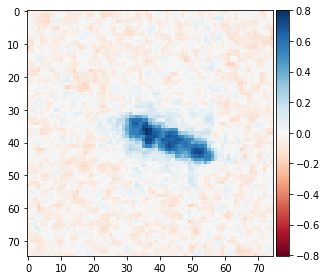

This is: Ship


In [27]:
from skimage.io import imshow
import matplotlib.pyplot as plt

ix = 100 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

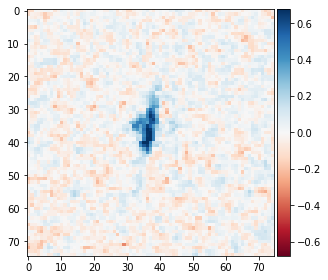

This is: Iceberg


In [28]:
ix = 110 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

# Creating the structure of Siamese Network

# Create two Inputs for each image - left_input and right_input

In [0]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

# Create a base Network in which both images will go through individually.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense

# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

# Process the left and right inputs to the same Base Network(base_network)

In [0]:
# Connect both left and right input to the same network
# Remember, they have the same weights
processed_a = base_network(left_input)
processed_b = base_network(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)

In [0]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

# Show the Summary of your Siamese Network

In [35]:
siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 18)           6912        input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 18)           0           sequential_1[1][0]         

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [37]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=1,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

313/313 [==============================] - 36s 114ms/step - loss: 0.6826 - accuracy: 0.5458 - val_loss: 0.7196 - val_accuracy: 0.3929
